### Background

This data comes thanks to all of those who helped us build our \$15,000 [hospital price database](https://www.dolthub.com/repositories/dolthub/hospital-price-transparency-v3). Creating distributed databases is our thing and we run contests like this all the time, literally. If you're interested in joining [our latest bounty](https://www.dolthub.com/repositories/dolthub/museum-collections) or just talking to us, you can hop on [Discord](https://discord.gg/tTwYVraPDM) to learn more.

In [188]:
import polars as pl
from polars import col
pl.__version__

'0.13.43'

### The goal

The current law requires that hospitals code their procedures with a generic code. This way you can compare prices between hospitals.

Of the 33% (or so) of hospitals that publish their chargemasters, and are in principle in compliance with the law, many of these hospitals only publish partial information, making price shopping [a lot like mattress shopping.](https://www.vox.com/2015/3/5/8151607/mattress-buying-tips-savings)

Our goal is to clean this real-world dataset and see if we can figure out how many rows can contain a code.

Then we'll see how many hospitals are following the law.

### Summary of the tutorial

In this real-world tutorial, you'll see me use [polars](https://github.com/pola-rs/polars), pandas, and [altair](https://altair-viz.github.io/) to chomp through, clean, and visualize this data.

The major lessons here are:

1. Getting comfortable with some features of [polars](https://github.com/pola-rs/polars), a fast and ergonomic dataframe library
1. The power in using `extract` combined with `when/then/otherwise` for data cleaning
1. Using the lazy API to pre-filter dataframes
1. Doing an analysis on a filtered dataframe (where we only select a few samples from each group before reading the dataframe into memory)

### Cleaning the hospitals dataset -- motivation

The [hospitals dataset at DoltHub](https://www.dolthub.com/repositories/dolthub/hospital-price-transparency-v3) contains 300M rows of prices. Each price is given at least a couple of codes (a primary `code` and an `internal_revenue_code`, sometimes more than one of each) which refer to how the procedure is billed. Billing codes are the standard for comparing hospital prices. If we know that a hospital charges \$2,000 for code `59410`, you can be pretty sure that you (or your insurer) are going to be paying about that price for a normal childbirth.

In [202]:
# an example of our prices data
!head -10 ../prices.csv

cms_certification_num,payer,code,internal_revenue_code,units,description,inpatient_outpatient,price,code_disambiguator
010001,BLUE ADVANTAGE [308003],HCPCS 82441,3018244101,,HC TEST FOR CHLOROHYDROCARBONS - POLYCHLORINATED BIPHENYLS,UNSPECIFIED,279.02,NONE
010001,BLUE CROSS OF ALA [200001],HCPCS 82441,3018244101,,HC TEST FOR CHLOROHYDROCARBONS - POLYCHLORINATED BIPHENYLS,UNSPECIFIED,279.02,NONE
010001,CARESOURCE [100121],HCPCS 82441,3018244101,,HC TEST FOR CHLOROHYDROCARBONS - POLYCHLORINATED BIPHENYLS,UNSPECIFIED,279.02,NONE
010001,FIRST HEALTH [308007],HCPCS 82441,3018244101,,HC TEST FOR CHLOROHYDROCARBONS - POLYCHLORINATED BIPHENYLS,UNSPECIFIED,279.02,NONE
010001,GEHA [100039],HCPCS 82441,3018244101,,HC TEST FOR CHLOROHYDROCARBONS - POLYCHLORINATED BIPHENYLS,UNSPECIFIED,279.02,NONE
010001,HUMANA GOLD CHOICE [450013],HCPCS 82441,3018244101,,HC TEST FOR CHLOROHYDROCARBONS - POLYCHLORINATED BIPHENYLS,UNSPECIFIED,279.02,NONE
010001,HUMANA [100052],HCPCS 82441,3018244101,,HC TEST FOR CHL

#### Where the codes are in our dataset

Hospitals, according to the CMS law, are required to post a chargemaster with a hospital-generic code. As they should be: if hospitals only used proprietary coding for their procedures there would be no way to compare prices between hospitals. Typically these universal codes are CPT codes ("current procedural terminology") which follow a specific pattern, but they can also be NDC and DRG codes (National Drug Code and Diagnostic Related Code, respectively.)

We'll do our best to extract CPT codes (as well as DRG and NDC codes) from the chargemasters as much as we reasonably can. Remember that the CMS law requires that these chargemasters be machine readable. If we can't figure out what the code is supposed to be from the chargemaster, then it's not machine readable. It's junk.


#### How codes were entered into the database

Some background on the structure of our data. Our bounty participants typically put the most generic code in the `code` column. This would be where the CPT code went. If there was a second code, it went in the `internal_revenue_code` column. A third code would have gone in the `code_disambiguator` column, but this turns out to not have been necessary.

However, because the codes are mixed -- some contain pharmacy codes, random codes, etc. -- it is a bit difficult to work with the data. Plus, it's not clear how many of our rows even have valid codes.

So I wrote a short cleaning pipeline to figure out the coding for each row, and see what fraction of rows were coded in some machine readable way.

### Making the pipeline: custom pipes

`pipes` are an easy way to chain data transformations together. In polars/pandas, it looks something like:

```python
out_df = in_df.pipe(transformation, **params).pipe(another_transformation, **params)
```

The first transformation we'll need is one that extracts the CPT codes from the codes column.

In [203]:
def extract_cpt(df: pl.DataFrame) -> pl.DataFrame:
    '''
    Extract CPT singlet codes
    '''
    
    # do some transformations
    
    return df

### A test dataframe

We'll make a simple dataframe to test out our data cleaning pipeline.

In [253]:
# this data is made-up, but is close to real data
testdf = pl.DataFrame({'code': ['  CPT/HCPC 0206009123 ', 
                                'NDC 0011-1231-12-', 
                                'CPT 99899 00123', 
                                'MS-DRG 1101112', 
                                'CPT 123', 
                                '12341-12345', 
                                '  CPT12345', 
                                'NDC 0012312311',
                                'MS123', 
                                '319',],
                       'description': ['Test tube insertion', 
                                       'Flexanderide 10mg', 
                                       'Heart Surgery with MCC', 
                                       'Neurosurgery',
                                       'Vaginal birth', 
                                       'Outpatient procedures', 
                                       'NDC 123456-1281', 
                                       'Insulin', 
                                       'Group therapy', 
                                       'Removal of sec. small bowel']})
print(testdf)

shape: (10, 2)
┌────────────────────────┬─────────────────────────────┐
│ code                   ┆ description                 │
│ ---                    ┆ ---                         │
│ str                    ┆ str                         │
╞════════════════════════╪═════════════════════════════╡
│   CPT/HCPC 0206009123  ┆ Test tube insertion         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ NDC 0011-1231-12-      ┆ Flexanderide 10mg           │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ CPT 99899 00123        ┆ Heart Surgery with MCC      │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ MS-DRG 1101112         ┆ Neurosurgery                │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...                    ┆ ...                         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│   CPT12345             ┆ NDC 123456-1281             │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ NDC 0012312311

### Simple cleaning

At the very least, we can write a quick function to clean the code column. This'll make it easier to do regex matching and joining later.

In [254]:
def clean(df: pl.DataFrame, colname) -> pl.DataFrame:
    return df.with_column(
        col(colname).str.strip().str.replace_all('^-|-$', '')
    )
    
print(testdf.pipe(clean, 'code'))

shape: (10, 2)
┌─────────────────────┬─────────────────────────────┐
│ code                ┆ description                 │
│ ---                 ┆ ---                         │
│ str                 ┆ str                         │
╞═════════════════════╪═════════════════════════════╡
│ CPT/HCPC 0206009123 ┆ Test tube insertion         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ NDC 0011-1231-12    ┆ Flexanderide 10mg           │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ CPT 99899 00123     ┆ Heart Surgery with MCC      │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ MS-DRG 1101112      ┆ Neurosurgery                │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...                 ┆ ...                         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ CPT12345            ┆ NDC 123456-1281             │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ NDC 0012312311      ┆ Insulin                     │
├╌╌╌╌╌╌╌╌╌╌╌╌

### The power of regex

We'll hunt for the CPT codes in the codes column. We'll use a few heuristics for finding them. To get those heuristics, we'll need to know what kind of junk is present in the database already, and how to distinguish that junk from valid codes to the greatest possible extent.

#### Heuristic 1: There's only one code type in each cell

If the cell contains the string 'NDC', 'MS-DRG', or 'CDM', it is overwhelmingly likely to *not* contain a CPT code.

#### Heuristic 2: A specific set of 5-char codes

CPT codes come mainly in two flavors:

1. CPT I: 5 digit numerical code from 00100 to 99499
2. CPT II: 5 digit alphanumerical code like `any('ACEGJKLMQTV')` + 4 digits or 4 digits + `any('ACEGJKLMQTV')`

We will hunt for explicitly these patterns.

In [206]:
def extract_cpt(df: pl.DataFrame) -> pl.DataFrame:
    '''
    Extract CPT singlet codes
    '''
    
    cpt_pats = ['\d{5}',       # simplified CPT I
                '[A-Z]\d{4}',  # simplified CPT II
                '\d{4}[A-Z]']  # simplified CPT II
    
    # to "extract" a pattern, it needs to be in parenthesis
    # and to extract multiple patterns with OR, they need to
    # have a bar char between them. A valid extraction string
    # looks something like 'abc(pat)'
    
    extraction_str = '|'.join([f'({pat})' for pat in cpt_pats])
    
    return df.with_column(
        
        pl.when(
            
            # Heuristic 1
            ~col('code').str.contains('NDC|MS|CDM')
            
        ).then(
            
            # Heuristic 2
            col('code').str.extract(extraction_str)
            
        ).otherwise(None).alias('extracted_cpt')
    )

testdf.pipe(extract_cpt)

code,description,extracted_cpt
str,str,str
""" CPT/HCPC 020...","""Test tube inse...","""02060"""
"""NDC 0011-1231-...","""Flexanderide 1...",null
"""CPT 99899 0012...","""Heart Surgery ...","""99899"""
"""MS-DRG 1101112...","""Neurosurgery""",null
"""CPT 123""","""Vaginal birth""",null
"""12341-12345""","""Outpatient pro...","""12341"""
""" CPT12345""","""NDC 123456-128...",null
"""NDC 0012312311...","""Insulin""",null
"""MS123""","""Group therapy""",null


We right away see some flaws here. 

1. Because there can be multiple CPT codes in a cell, we'll need a way to extract them all
2. Sometimes we're extracting codes that we shouldn't be (row 3 is not a valid CPT code)
3. The last row, which is a range of CPT codes, should probably be handled separately. Plus, these "ranges" might actually be longer codes with dashes in the middle (unless they're specifically marked as CPT). Let's filter them out for now.
4. 99899 isn't really a valid CPT code. More on that later.

### Solution addressing (1): `str.extract_all` to the rescue

This undocumented polars function allows us to extract all the CPT codes in a cell in one stroke.

### Solution addressing (2): regex word boundaries

By putting `\b` on either side of a word, we can force our five-char codes to not be part of a larger digit string.

### Solution addressing (3): eliminate dashed digit/char strings with a `str.replace_all`

We'll simply eliminate those patterns entirely before we do regex matching. (We could do this with negative lookaheads, but these aren't implemented in the rust regex parser.)

In [207]:
def extract_cpt(df: pl.DataFrame) -> pl.DataFrame:
    '''
    Extract CPT singlet codes
    '''
    
    cpt_pats = ['\d{5}',       # simplified CPT I
                '[A-Z]\d{4}',  # simplified CPT II
                '\d{4}[A-Z]']  # simplified CPT II
    
    # to "extract" a pattern, it needs to be in parenthesis
    # and to extract multiple patterns with OR, they need to
    # have a bar char between them. A valid extraction string
    # looks something like 'abc(pat)'
    
    extraction_str = '|'.join([fr'\b({pat})\b' for pat in cpt_pats])
    
    return df.with_column(
        
        col('code').str.replace_all(r'\b\d{5}-\d{5}\b', '').alias('code_cleaned')
        
    ).with_column(
        
        pl.when(
            
            # Heuristic 1
            ~col('code_cleaned').str.contains('NDC|MS|CDM')
            
        ).then(
            
            # Heuristic 2
            col('code_cleaned').str.extract_all(extraction_str)
            
        ).otherwise(None).alias('extracted_cpt')
    )

testdf.pipe(extract_cpt)

code,description,code_cleaned,extracted_cpt
str,str,str,list[str]
""" CPT/HCPC 020...","""Test tube inse...",""" CPT/HCPC 020...",null
"""NDC 0011-1231-...","""Flexanderide 1...","""NDC 0011-1231-...",null
"""CPT 99899 0012...","""Heart Surgery ...","""CPT 99899 0012...","[""99899"", ""00123""]"
"""MS-DRG 1101112...","""Neurosurgery""","""MS-DRG 1101112...",null
"""CPT 123""","""Vaginal birth""","""CPT 123""",null
"""12341-12345""","""Outpatient pro...","""""",null
""" CPT12345""","""NDC 123456-128...",""" CPT12345""",null
"""NDC 0012312311...","""Insulin""","""NDC 0012312311...",null
"""MS123""","""Group therapy""","""MS123""",null


Cool! We're on our way to doing a good cleanup on the dataset.

### the "raw string" r''

If you've never seen `r'some string'` before, the `r` just stops what's inside the quotations from being escaped with slashes. So, for example, `r'\n'` is *really* slash n, as opposed to `'\n'`, which is a newline.

In [208]:
print(r'This is \n not a newline')
print('This is a \n newline')

This is \n not a newline
This is a 
 newline


This prevents the `\b` from being parsed as something else, so that the regex engine can work with it properly (and treat it as a word boundary.) Without the `r`, you need double slashes.

In [209]:
print(r'A raw string: \b and \\b')
print('A regular string \\b and \b')

A raw string: \b and \\b
A regular string \b and


### Convenience functions

#### `in_col`
Inside `str.contains` should be a list of ORs. 

```python
# Heuristic 1
~col('code_cleaned').str.contains('NDC|MS|CDM')
```

But this will be cumbersome to write once we have a lot of stuff to put in there. It would be nice if we could just pass a list of strings directly to a function.

In [210]:
def in_col(colname, words): 
    return col(colname).str.contains('|'.join(words.split()))

def extract_all_from(colname, words):
    words_str = '|'.join([fr'\b{word}\b' for word in words.split()])
    return col(colname).str.extract_all(words_str)

def clear_all_from(colname, words):
    words_str = '|'.join([fr'{word}' for word in words.split()])
    return col(colname).str.replace_all(words_str, '')

This allows us to replace, for example:
```python
# ~col('code_cleaned').str.contains('NDC|MS|CDM') 
in_col('code_cleaned', 'NDC MS CDM')

# cpt_pats = ['\d{5}', '[A-Z]\d{4}', '\d{4}[A-Z]'] 
# col('code_cleaned').str.extract_all(extraction_str)
cpt_pats = '\d{5} [A-Z]\d{4} \d{4}[A-Z]'
extract_all_from('code_cleaned', cpt_pats)
```

which looks neater to me and will get easier to work with.

### Writing the extraction function with our new functions
results in a much cleaner transformation.

In [211]:
def extract_cpt(df: pl.DataFrame) -> pl.DataFrame:
    '''
    Extract CPT singlet codes
    '''
    
    cpt_pats = '\d{5} [A-Z]\d{4} \d{4}[A-Z]'
    
    return df.with_column(
        
        clear_all_from('code', '\d{5}-\d{5}').alias(f'code_cleaned')
        
    ).with_column(
        
        pl.when(
            
            # Heuristic 1
            ~in_col('code_cleaned', 'NDC MS CDM')
            
        ).then(
            
            # Heuristic 2
            extract_all_from('code_cleaned', cpt_pats)
            
        ).otherwise(None).alias('extracted_cpt')
    )

testdf.pipe(extract_cpt)

code,description,code_cleaned,extracted_cpt
str,str,str,list[str]
""" CPT/HCPC 020...","""Test tube inse...",""" CPT/HCPC 020...",null
"""NDC 0011-1231-...","""Flexanderide 1...","""NDC 0011-1231-...",null
"""CPT 99899 0012...","""Heart Surgery ...","""CPT 99899 0012...","[""99899"", ""00123""]"
"""MS-DRG 1101112...","""Neurosurgery""","""MS-DRG 1101112...",null
"""CPT 123""","""Vaginal birth""","""CPT 123""",null
"""12341-12345""","""Outpatient pro...","""""",null
""" CPT12345""","""NDC 123456-128...",""" CPT12345""",null
"""NDC 0012312311...","""Insulin""","""NDC 0012312311...",null
"""MS123""","""Group therapy""","""MS123""",null


### Continuing on
Let's add the detail needed to make this extraction more realistic.

1. We'll only use valid 5 digit CPT codes (so we'll need a more advanced regex). I used https://3widgets.com to get a regex that wil capture numbers from 00100-99499, and added the alphanumerical ones manually.
2. It sometimes happens that codes are marked as CPT codes but don't fit the regex pattern. Any time there's a CPT/HCPCS string in the cell we're going to keep all the (reasonable) codes that are in it, even if they don't match the exact pattern of being a 5 digit string. They might have just had some zeros lopped off the front or something like that.

In [212]:
def extract_cpt(df: pl.DataFrame) -> pl.DataFrame:
    '''
    Extract CPT singlet codes
    '''
    
    cpt_pats = '''0010[0-9] 001[1-9][0-9] 00[2-9][0-9]{2} 
                0[1-9][0-9]{3} [1-8][0-9]{4} 9[0-8][0-9]{3} 
                99[0-4][0-9]{2} [ACEGJKLMQTV]\d{4} \d{4}[ACEGJKLMQTV]'''
    
    return df.with_column(
        
        clear_all_from('code', '\\b\w{5}-\w{5}\\b \\b?CPT\\b? \\b?HCPCS?\\b?').alias(f'code_cleaned'),
        
    ).with_column(
        
        pl.when(            
            # If we have a code to exclude...
            in_col('code', 'NDC MS CDM DRG PH\d+ ITM')
        ).then(
            # ...ignore the cell
            None
        ).when(
            # If we have an explicit CPT code...
            in_col('code', 'CPT HCPCS? CPT\s?/?HCPCS? HCPCS\s?/?CPT')
        ).then(
            # greedily take the candidates
            extract_all_from('code_cleaned', cpt_pats + ' ([A-Z]|\d){1,2}?\d{1,4}([A-Z]|\d){2} \\b\d{3}\\b')
        ).otherwise(
            # If we have no information about the code,
            # just select the good candidates
            extract_all_from('code_cleaned', cpt_pats)
            
        ).alias('extracted_cpt')
    ).drop('code_cleaned')

testdf.pipe(extract_cpt)

code,description,extracted_cpt
str,str,list[str]
""" CPT/HCPC 020...","""Test tube inse...",null
"""NDC 0011-1231-...","""Flexanderide 1...",null
"""CPT 99899 0012...","""Heart Surgery ...","[""99899"", ""00123""]"
"""MS-DRG 1101112...","""Neurosurgery""",null
"""CPT 123""","""Vaginal birth""","[""123""]"
"""12341-12345""","""Outpatient pro...",null
""" CPT12345""","""NDC 123456-128...","[""12345""]"
"""NDC 0012312311...","""Insulin""",null
"""MS123""","""Group therapy""",null


### Repeating for the other code types
We'll do the same thing to extract NDC codes and DRG codes cleanly from our dataset.

In [213]:
def extract_ndc(df: pl.DataFrame) -> pl.DataFrame:
    '''
    Extract NDC singlet codes
    '''
    
    ndc_pats = '''\d{4}-\d{4}-\d{2} \d{5}-\d{3}-\d{2} \d{5}-\d{4}-\d{1}'''
    
    return df.with_column(
        clear_all_from('code', '_\d+').alias('code_cleaned')
    ).with_column(
        pl.when(            
            in_col('code', 'CPT HCPCS? CPT\s?/?HCPCS? HCPCS\s?/?CPT MS CDM DRG PH\d+ ITM')
        ).then(
            # if the code column doesn't have an NDC code, let's check the description column
            pl.when(
                in_col('description', 'NDC')
            ).then(
                extract_all_from('description', ndc_pats + ' ([0-9]|-){12} ([0-9]|-){11} \d{10}')
            ).otherwise(None)
        ).when(
            in_col('code', 'NDC')
        ).then(
            extract_all_from('code_cleaned', ndc_pats + ' ([0-9]|-){12} ([0-9]|-){11} \d{10}')
        ).otherwise(
            extract_all_from('code_cleaned', ndc_pats)
        ).alias('extracted_ndc')
    ).drop('code_cleaned')

testdf.pipe(extract_ndc)

code,description,extracted_ndc
str,str,list[str]
""" CPT/HCPC 020...","""Test tube inse...",null
"""NDC 0011-1231-...","""Flexanderide 1...","[""0011-1231-12""]"
"""CPT 99899 0012...","""Heart Surgery ...",null
"""MS-DRG 1101112...","""Neurosurgery""",null
"""CPT 123""","""Vaginal birth""",null
"""12341-12345""","""Outpatient pro...",null
""" CPT12345""","""NDC 123456-128...","[""123456-1281""]"
"""NDC 0012312311...","""Insulin""","[""0012312311""]"
"""MS123""","""Group therapy""",null


In [214]:
def extract_drg(df: pl.DataFrame) -> pl.DataFrame:
    '''
    Extract DRG singlet codes
    '''
    
    drg_pats = '''\d{1,3}'''
    
    return df.with_column(
        clear_all_from('code', ' \\b?MS\\b? \\b?MS-DRG\\b? \\b?DRG\\b?').alias(f'code_cleaned'),
    ).with_column(
        pl.when(            
            in_col('code', 'CPT HCPCS? CPT\s?/?HCPCS? HCPCS\s?/?CPT NDC CDM PH\d+ ITM')
        ).then(None).when(
            in_col('code', drg_pats + ' MS-DRG DRG MS')
        ).then(
            extract_all_from('code_cleaned', drg_pats)
        ).otherwise(None).alias('extracted_drg')
    ).drop('code_cleaned')

testdf.pipe(extract_drg)

code,description,extracted_drg
str,str,list[str]
""" CPT/HCPC 020...","""Test tube inse...",null
"""NDC 0011-1231-...","""Flexanderide 1...",null
"""CPT 99899 0012...","""Heart Surgery ...",null
"""MS-DRG 1101112...","""Neurosurgery""",null
"""CPT 123""","""Vaginal birth""",null
"""12341-12345""","""Outpatient pro...",null
""" CPT12345""","""NDC 123456-128...",null
"""NDC 0012312311...","""Insulin""",null
"""MS123""","""Group therapy""","[""123""]"


## More problems

Some of the codes in the codes column are superficially CPT codes, but may also be ICD-10 codes. There's some overlap. We won't be able to distinguish them based on the code alone. The best we can do is provide multiple matches.

These ICD-10 codes can be mapped to DRG codes (diagnostic-related-groups). Since we already have a column for them, we'll convert those codes to DRG codes using a table I found on the CMS website.

https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AcuteInpatientPPS/MS-DRG-Classifications-and-Software.html

(I had to manually remove the header from appendix_B.txt to be able to read it.)

### The table which maps from ICD-10 to DRG (not used, but instructive)

This table is kind of a mess. There are missing rows and there are code ranges, and importantly, the file is fixed-width formatted.

Thankfully, one of my friends (@abmyii on our Discord) pointed out that pandas has a `.read_fwf` method for reading fixed-width files.

In [215]:
!head -n 20 appendix_B.txt

 I10 Dx  MDC DRG(s)      ICD-10-CM Description
 A000    06  371-373     Cholera due to Vibrio cholerae 01, biovar cholerae
 A001    06  371-373     Cholera due to Vibrio cholerae 01, biovar eltor
 A009    06  371-373     Cholera, unspecified
 A0100   18  867-869     Typhoid fever, unspecified
 A0101   18  867-869     Typhoid meningitis
 A0102   18  867-869     Typhoid fever with heart involvement
 A0103   18  867-869     Typhoid pneumonia
 A0104   18  867-869     Typhoid arthritis
 A0105   18  867-869     Typhoid osteomyelitis
 A0109   18  867-869     Typhoid fever with other complications
 A011    18  867-869     Paratyphoid fever A
 A012    18  867-869     Paratyphoid fever B
 A013    18  867-869     Paratyphoid fever C
 A014    18  867-869     Paratyphoid fever, unspecified
 A020    06  371-373     Salmonella enteritis
 A021    18  870-872     Salmonella sepsis
         25  974-976     
 A0220   18  867-869     Localized salmonella infection, unspecified
         25  974-976     


### How we'll deal with this

1. We'll use `.fill_null('forward')` to turn

```sql
 A021    18  870-872     Salmonella sepsis
         25  974-976     
```
into
```sql
 A021    18  870-872     Salmonella sepsis
 A021    25  974-976     Salmonella sepsis
```

2. We'll split the array on the hyphen, cast the strings to ints, and then create a range (with `pl.arange`) from the first to the last element

```sql
"371-373" --> [371, 372, 373] 
"951"     --> [951]
```

3. We'll explode on that new column, and convert numbers like 1 back to '001' with the `.zfill` method.

In [216]:
import pandas as pd
(pl
     .DataFrame(pd.read_fwf('appendix_B.txt'), columns = ['dx', 'mdc', 'drgs', 'icd-10-description'])
     .fill_null('forward')
     .with_column(
         col('drgs').str.split('-').arr.eval(pl.element().cast(int, strict = False)).alias('drg_arr')
     ).with_column(
         pl.arange(col('drg_arr').arr.first(), col('drg_arr').arr.last() + 1)
     ).explode('drg_arr')
     .drop('drgs')
     .rename({'drg_arr':'drg'})
     .with_column(
         col('drg').cast(str).str.zfill(3)
     )
    ).sample(5)

dx,mdc,icd-10-description,drg
str,str,str,str
"""S56116""","""24""","""Strain of flex...","""964"""
"""S30864""","""24""","""Insect bite (n...","""965"""
"""S52362""","""24""","""Displaced segm...","""964"""
"""S62349""","""08""","""Nondisplaced f...","""563"""
"""S02611""","""24""","""Fracture of co...","""965"""


### Seeing how many rows we can match to a code

Now it's time to see if we can clean our real-life data.

In [16]:
lf = pl.scan_csv('../prices.csv', n_rows = 20_000_000, infer_schema_length = 10_000_000, encoding = 'utf8-lossy')

In [17]:
lf.fetch(2)

cms_certification_num,payer,code,internal_revenue_code,units,description,inpatient_outpatient,price,code_disambiguator
str,str,str,str,str,str,str,str,str
"""010001""","""BLUE ADVANTAGE...","""HCPCS 82441""","""3018244101""",null,"""HC TEST FOR CH...","""UNSPECIFIED""","""279.02""","""NONE"""
"""010001""","""BLUE CROSS OF ...","""HCPCS 82441""","""3018244101""",null,"""HC TEST FOR CH...","""UNSPECIFIED""","""279.02""","""NONE"""


In [18]:
def extract_medical_coding(df: pl.DataFrame) -> pl.DataFrame:
    
    return (df.pipe(clean, 'code')
              .pipe(extract_ndc)
              .pipe(extract_cpt)
              .pipe(extract_drg))

def nullify_values(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.when(
            col('code') == 'NONE'
        ).then(None).otherwise(
            col('code')
        ).alias('code'),
        pl.when(
            col('internal_revenue_code') == 'NONE'
        ).then(None).otherwise(
            col('internal_revenue_code')
        ).alias('internal_revenue_code'),
        pl.when(
            col('inpatient_outpatient') == 'UNSPECIFIED'
        ).then(None).otherwise(
            col('inpatient_outpatient')
        ).alias('inpatient_outpatient')
      ])

In [1716]:
df = (lf.pipe(extract_medical_coding)
      .drop(['units', 'code_disambiguator'])
      .pipe(nullify_values)
     ).collect()

unmatched = df.filter(
    col('extracted_ndc').is_null() & 
    col('extracted_drg').is_null() &
    col('extracted_cpt').is_null() 
)

In [1388]:
len(unmatched)/len(df)

0.5693638

We're only able to match about 56% of the rows to a well-known code.

## Sampling groups from the dataframe

The original dataset is ginormous. 300M rows. Way too big to read into memory. But to get a feel for the data, we'll sample 10,000 rows from every hospital using a trick that Ritchie Vink showed me in this [StackOverflow question that I asked](https://stackoverflow.com/questions/72633461/sample-from-each-group-in-polars-dataframe/72636610#72636610).

While we won't have the total data from each hospital, any conclusions we draw should be accurate down to .01% of all the rows considered. If we say, the hospital has "no values" of something, we mean that 99.99% of the rows meet that condition.

In [457]:
dtype = {'cms_certification_num': str}

kwargs = {'infer_schema_length': 1_000_000,
          'low_memory': True,
          'encoding': 'utf8-lossy',
          'dtype': dtype}

cols_to_keep = ['cms_certification_num', 
                'payer', 
                'code', 
                'internal_revenue_code', 
                'description', 
                'inpatient_outpatient', 
                'price']

# Doing this directly with filter doesn't work -- bug?
lf = (pl.scan_csv('../prices.csv', **kwargs)
      .with_column(
          (pl.arange(0, pl.count()).shuffle().over('cms_certification_num') < 10_000).alias('selected')
      ).filter(col('selected'))
      .select(cols_to_keep)
     )

In [458]:
%%time

df = lf.collect()

CPU times: user 4min 9s, sys: 6min 58s, total: 11min 7s
Wall time: 15min 28s


This gives us 1000 samples from each hospital to analyze, or up to that, if they exist.

In [459]:
df = df.pipe(extract_medical_coding).pipe(nullify_values)

To get a more fine-grained picture of the missing data, we'll see how many codes we've identified per-row, per hospital.

In [460]:
data = df.with_column(
    col('cms_certification_num').cast(str).str.zfill(6)
).groupby('cms_certification_num').agg([
    pl.count().alias('len_group'),
    col(['extracted_cpt', 'extracted_ndc', 'extracted_drg']).arr.lengths().sum()
]).with_columns([
    pl.sum(['extracted_cpt', 'extracted_ndc', 'extracted_drg']).alias('total_identifiable'),
    (pl.sum(['extracted_cpt', 'extracted_ndc', 'extracted_drg'])/col('len_group')).alias('ided_codes_per_row'),
]).sort('ided_codes_per_row')

A lot of hospitals have more than one code per row, which is fine.

In [461]:
source = data.with_column(
    pl
    .when(
        col('ided_codes_per_row') < .25
    ).then('0-25%')
    .when(
        (col('ided_codes_per_row') >= .25) & (col('ided_codes_per_row') < .50)
    )
    .then('25-50%')
    .when(
        (col('ided_codes_per_row') > .50) & (col('ided_codes_per_row') > .75)
    ).then('50-75%')
    .otherwise('75%+').alias('fraction_coded')
).groupby('fraction_coded').agg(pl.count()).to_pandas()

In [462]:
source

,fraction_coded,count
0,50-75%,826
1,75%+,455
2,25-50%,132
3,0-25%,416


<AxesSubplot:>

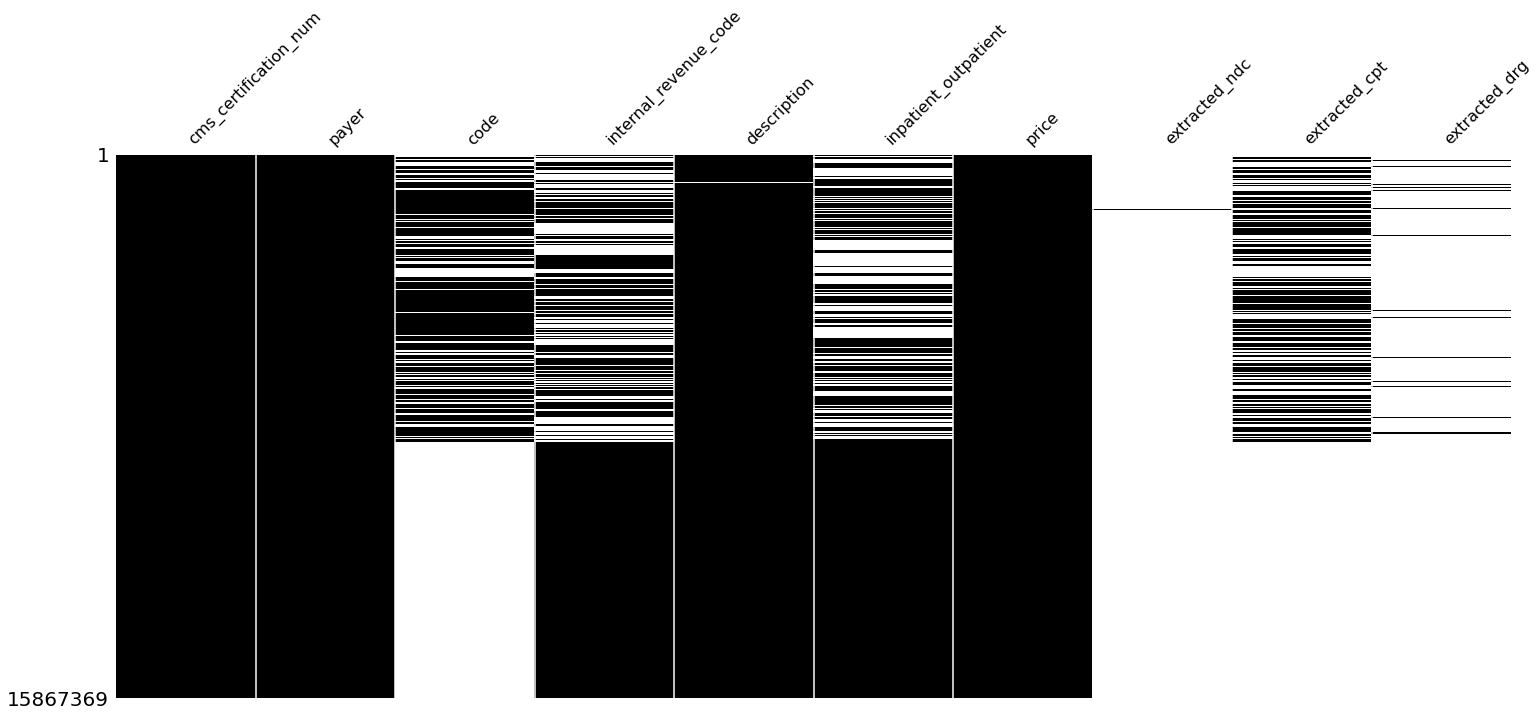

In [464]:
import missingno as msno
%matplotlib inline
msno.matrix(df.to_pandas(), color = (0, 0, 0), sparkline = False)

## Estimating compliance

### How many hospitals have chargemasters with no generic codes at all?

In [502]:
(df
 .groupby(['cms_certification_num'])
 .agg(
     (
         col('extracted_ndc').is_null() & col('extracted_drg').is_null() & col('extracted_cpt').is_null()
     ).alias('all_codes'))
 .filter(
     ~col('all_codes').arr.contains(False)
 )['cms_certification_num'].len())

261

Let's see how many total we have:

In [518]:
len(df.groupby('cms_certification_num').count())

1835

So out of 1835 hospitals, we have 

In [519]:
261/1835

0.1422343324250681

or 14% without any generic codes at all.

### How many hospitals do not contain at least one insurance payer

In [558]:
(df
 .groupby(['cms_certification_num'])
 .agg(
     (
         ~col('payer').str.contains('GROSS CHARGE|\bMAX\b|\bMIN\b|CASH PRICE').alias('payer')
     ).alias('nonins_payer'))
 .filter(
     ~col('nonins_payer').arr.contains(True)
 ))['cms_certification_num'].len()

380

In [559]:
380/1835

0.20708446866485014

In [ ]:
import altair as alt
alt.renderers.enable('jupyterlab')

base = alt.Chart(source, title = {
      "text": ["Compliance, but not really"], 
      "subtitle": [
          "Hospitals are required to post machine-readable chargemasters.", 
          "Only ", 
          "Such codes allow procedures to be compared between hospitals."
      ],
      "color": "black",
      "subtitleColor": "black"
    })

bar = base.mark_bar().encode(
    y=alt.Y('fraction_coded', title = 'Fraction of rows with a valid code'),
    x='count',
)

bar.properties(height = 200, width = 800)

18% are missing at least 